# Time Series of Price Anomaly Detection Expedia

## Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## EDA and Preprocessing Data

We are going to slice a subset of the training.csv set like so:
* Select one single hotel which has the most data point property_id = 104517 .
* Select visitor_location_country_id = 219 , as we know from the another analysis that country id 219 is the Unites States. The reason we do that is to unify the price_usd column. Since different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay. And we know that price displayed to US visitors is always per night and without taxes.
* Select search_room_count = 1.
* Select the features we need: date_time, price_usd, srch_booking_window, srch_saturday_night_bool.

In [24]:
expedia = pd.read_csv('train.csv')

In [69]:
df = expedia.loc[expedia['prop_id'] == 104517]
df = df.loc[df['srch_room_count'] == 1]
df = df.loc[df['visitor_location_country_id'] == 219]
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [70]:
df['date_time'].min(), df['date_time'].max()

('2012-11-01 02:48:30', '2013-06-30 22:50:21')

After slice and dice, this is the data we will be working with:

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2041 to 9917395
Data columns (total 4 columns):
date_time                   3049 non-null object
price_usd                   3049 non-null float64
srch_booking_window         3049 non-null int64
srch_saturday_night_bool    3049 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


In [72]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
df['price_usd'].describe()

count   3049.000
mean     112.939
std      113.374
min        0.120
25%       67.000
50%      100.000
75%      141.000
max     5584.000
Name: price_usd, dtype: float64

At this point, we have detected one extreme anomaly which was the Max price_usd at 5584.
If an individual data instance can be considered as anomalous with respect to the rest of the data, we call it Point Anomalies (e.g. purchase with large transaction value). We could go back to check the log to see what was it about. After a little bit investigation, I guess it was either a mistake or user searched a presidential suite by accident and had no intention to book or view. In order to find more anomalies that are not extreme, I decided to remove this one.

In [73]:
expedia.loc[(expedia['price_usd'] == 5584) & (expedia['visitor_location_country_id'] == 219)]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
2905344,195154,2013-04-07 20:59:07,5,219,nan,nan,219,104517,4,4.000,...,nan,nan,nan,nan,-1.000,0.000,28.000,0,nan,0


In [74]:
df = df.loc[df['price_usd'] < 5584]

At this point, I am sure you have found that we are missing something, that is, we do not know what room type a user searched for, the price for a standard room could be very different with the price for a King bed room with Ocean View. Keep this in mind, for the demonstration purpose, we have to continue.

## Time Series Visualizations

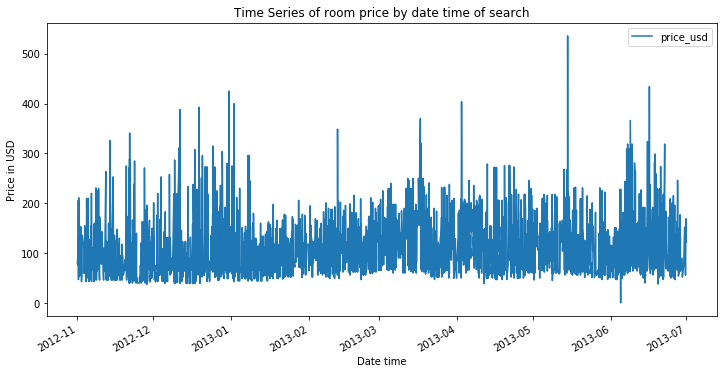

In [75]:
# plot the data
df.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search');

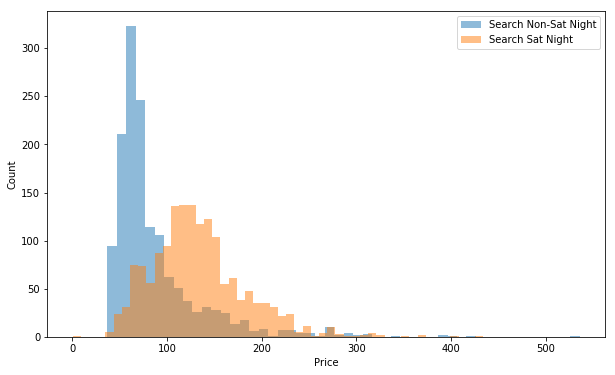

In [76]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

In [77]:
df['srch_saturday_night_bool'].value_counts()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64

In general, the price is more stable and lower when searching Non-Saturday night. And the price goes up when searching Saturday night. Seems this property gets popular during the weekend.

## Clustering-Based Anomaly Detection

### k-means algorithm

k-means is a widely used clustering algorithm. It creates ‘k’ similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies. Before we start k-means clustering, we use elbow method to determine the optimal number of clusters.

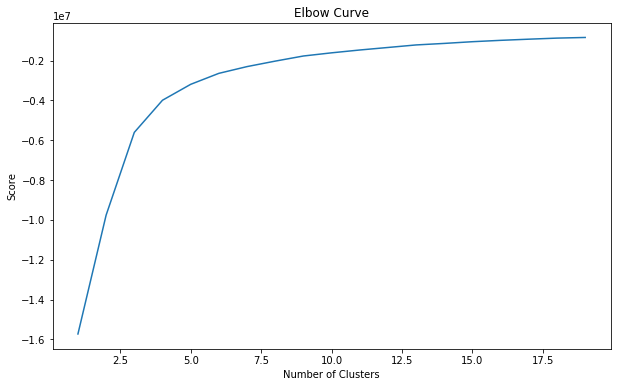

In [78]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above elbow curve, we see that the graph levels off after 10 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable; in this case price_usd.
we set n_clusters=10, and upon generating the k-means output use the data to plot the 3D clusters.

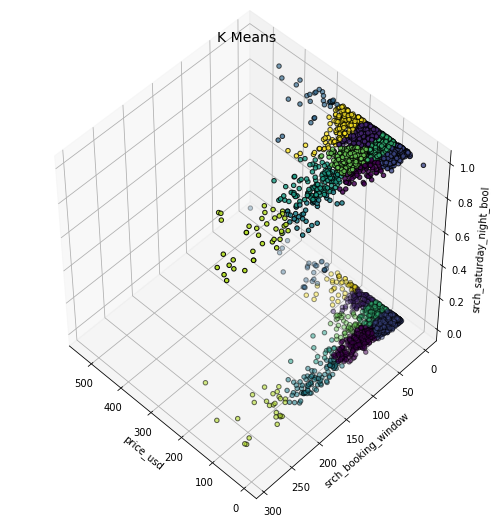

In [79]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

Now we need to find out the number of components (features) to keep.

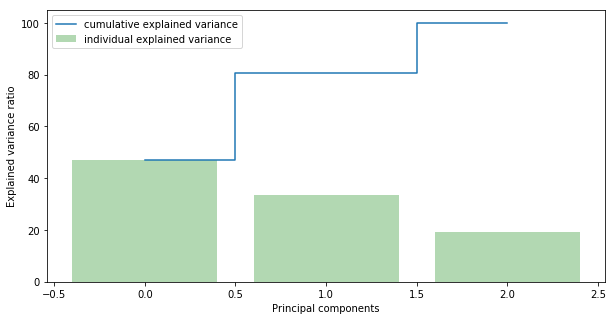

In [80]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

We see that the first component explains almost 50% of the variance. The second component explains over 30%. However, we’ve got to notice that almost none of the components are really negligible. The first 2 components contain over 80% of the information. So, we will set n_components=2.


The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters. We use the following steps to find and visualize anomalies.

* Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
* We use outliers_fraction to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, I estimate outliers_fraction=0.01, since it is the percentage of observations that should fall over the absolute value 3 in the Z score distance from the mean in a standardized normal distribution.
* Calculate number_of_outliers using outliers_fraction.
* Set threshold as the minimum distance of these outliers.
* The anomaly result of anomaly1 contains the above method Cluster (0:normal, 1:anomaly).
* Visualize anomalies with cluster view.
* Visualize anomalies with Time Series view.

In [81]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [82]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    661
3    591
9    429
6    355
1    354
8    212
5    152
4    149
2     79
7     66
Name: cluster, dtype: int64

In [83]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principal_feature1,principal_feature2
0,2012-11-01 02:48:30,84.000,19,0,0,-0.890,-0.522
1,2012-11-01 03:06:43,78.000,16,1,9,0.231,-0.272
2,2012-11-01 09:04:18,114.000,56,1,1,0.567,0.547
3,2012-11-01 09:11:03,76.000,56,1,1,0.156,0.582
4,2012-11-01 10:15:25,128.000,0,1,3,0.794,-0.659


In [84]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

C:\Users\Darwoft\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


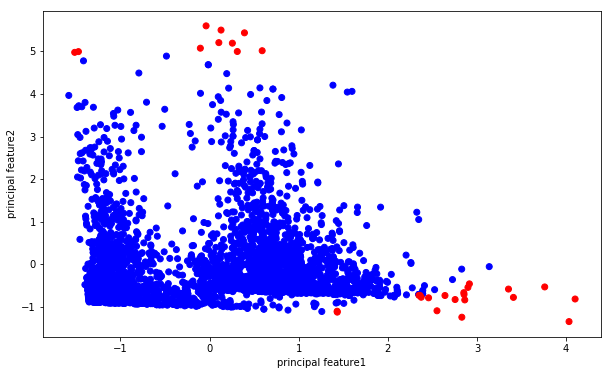

In [85]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [86]:
df.anomaly1.value_counts()

0    3018
1      30
Name: anomaly1, dtype: int64

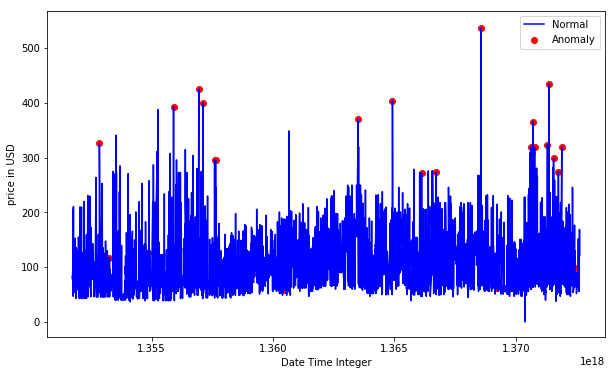

In [87]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

It seems that the anomalies detected by k-means clustering were either some of very high rates or some of very low rates.

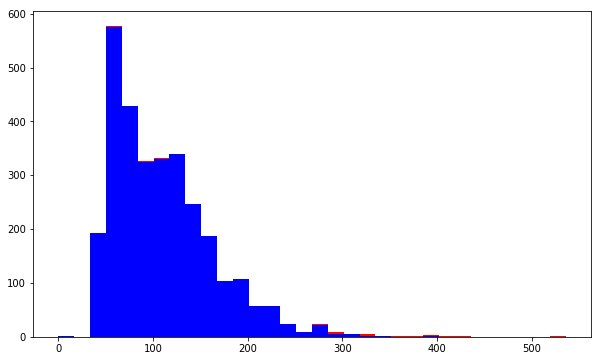

In [88]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

## Isolation Forests For Anomaly Detection

Isolation Forest detects anomalies purely based on the fact that anomalies are data points that are few and different. The anomalies isolation is implemented without employing any distance or density measure. This method is fundamentally different from clustering based or distance based algorithms.
* When applying an IsolationForest model, we set contamination = outliers_fraction, that is telling the model that the proportion of outliers in the data set is 0.01.
* fit and predict(data) performs outlier detection on data, and returns 1 for normal, -1 for anomaly.
* Finally, we visualize anomalies with Time Series view.


C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


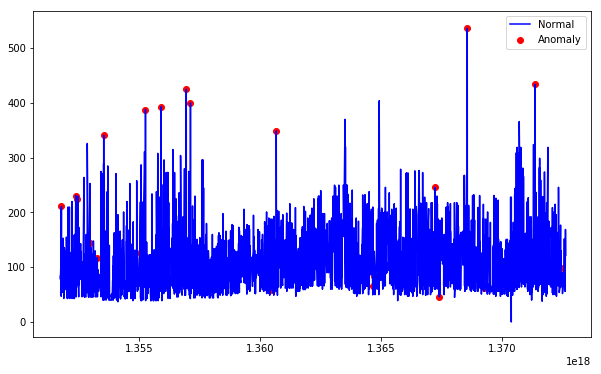

In [89]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly2'] = pd.Series(model.predict(data))
# df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )

fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [90]:
df['anomaly2'].unique()

array([ 1, -1], dtype=int64)

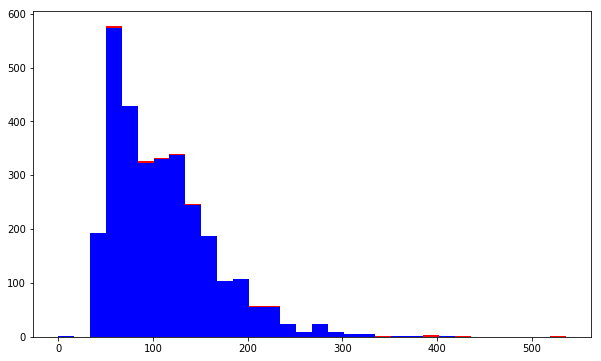

In [91]:
# visualisation of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

## Support Vector Machine-Based Anomaly Detection

A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems that learns a decision function for anomaly detection: classifying new data as similar or different to the training set.

### OneClassSVM

According to the paper: Support Vector Method for Novelty Detection. SVMs are max-margin methods, i.e. they do not model a probability distribution. The idea of SVM for anomaly detection is to find a function that is positive for regions with high density of points, and negative for small densities.

* When fitting OneClassSVM model, we set nu=outliers_fraction, which is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors, and must be between 0 and 1. Basically this means the proportion of outliers we expect in our data.
* Specifies the kernel type to be used in the algorithm: rbf. This will enable SVM to use a non-linear function to project the hyperspace to higher dimension.
* gamma is a parameter of the RBF kernel type and controls the influence of individual training samples - this effects the "smoothness" of the model. Through experimentation, I did not find any significant difference.
* predict(data) perform classification on data, and because our model is an one-class model, +1 or -1 is returned, and -1 is anomaly, 1 is normal.

C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


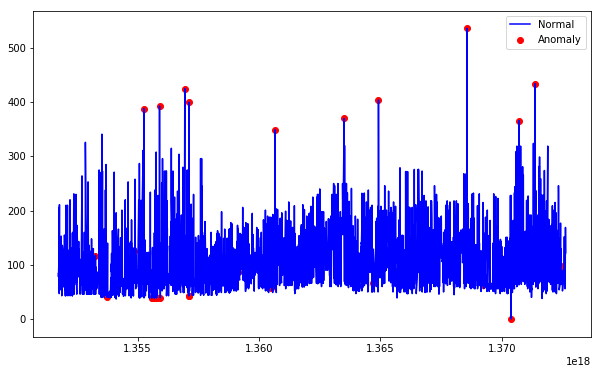

In [92]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
 
df['anomaly3'] = pd.Series(model.predict(data))
# df['anomaly3'] = df['anomaly3'].map( {1: 0, -1: 1} )
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label ='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

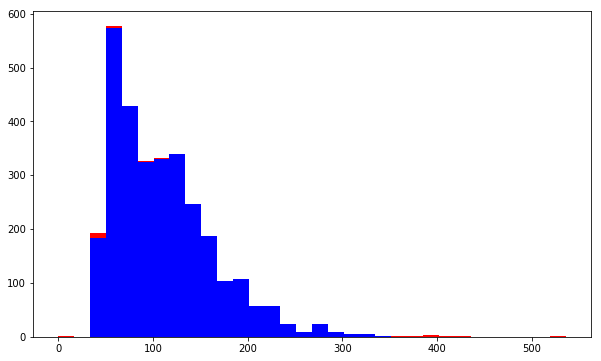

In [93]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();